In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import os
import json

In [2]:
# Plotting defaults
font_list = font_manager.findSystemFonts(fontpaths=["/gstore/home/tsenga5/modules/fonts"])
for font in font_list:
    font_manager.fontManager.addfont(font)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
def import_classes_branch_points(json_path):
    with open(json_path, "r") as f:
        d = json.load(f)
        return d["classes"], \
            [(tuple(trip[0]), trip[1], trip[2]) for trip in d["branches"]]

In [5]:
models_base_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/"

model_path = os.path.join(models_base_path, "fmnist_continuous_branched_minb10/2/epoch_120_ckpt.pth")

In [6]:
branch_points_path = "/gstore/home/tsenga5/branched_diffusion/data/config/classes_branch_points/fmnist/all_classes_minb10.json"

In [7]:
# Define the branches
classes, branch_defs = import_classes_branch_points(branch_points_path)

input_shape = (1, 28, 28)

In [8]:
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

In [9]:
out_path = "/gstore/home/tsenga5/branched_diffusion/figures/fmnist_hybrid_transmutation"

os.makedirs(out_path, exist_ok=True)

In [10]:
branch_point_examples = [
    (4, 6, 0.35035035035035034),
    (5, 7, 0.42842842842842843)
]

### Create data loader

In [11]:
dataset = torchvision.datasets.FashionMNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [12]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Import the model

In [13]:
model = model_util.load_model(
    image_unet.MultitaskMNISTUNetTimeConcat, model_path
).to(DEVICE)

### Hybrids

Branch point between 4 and 6


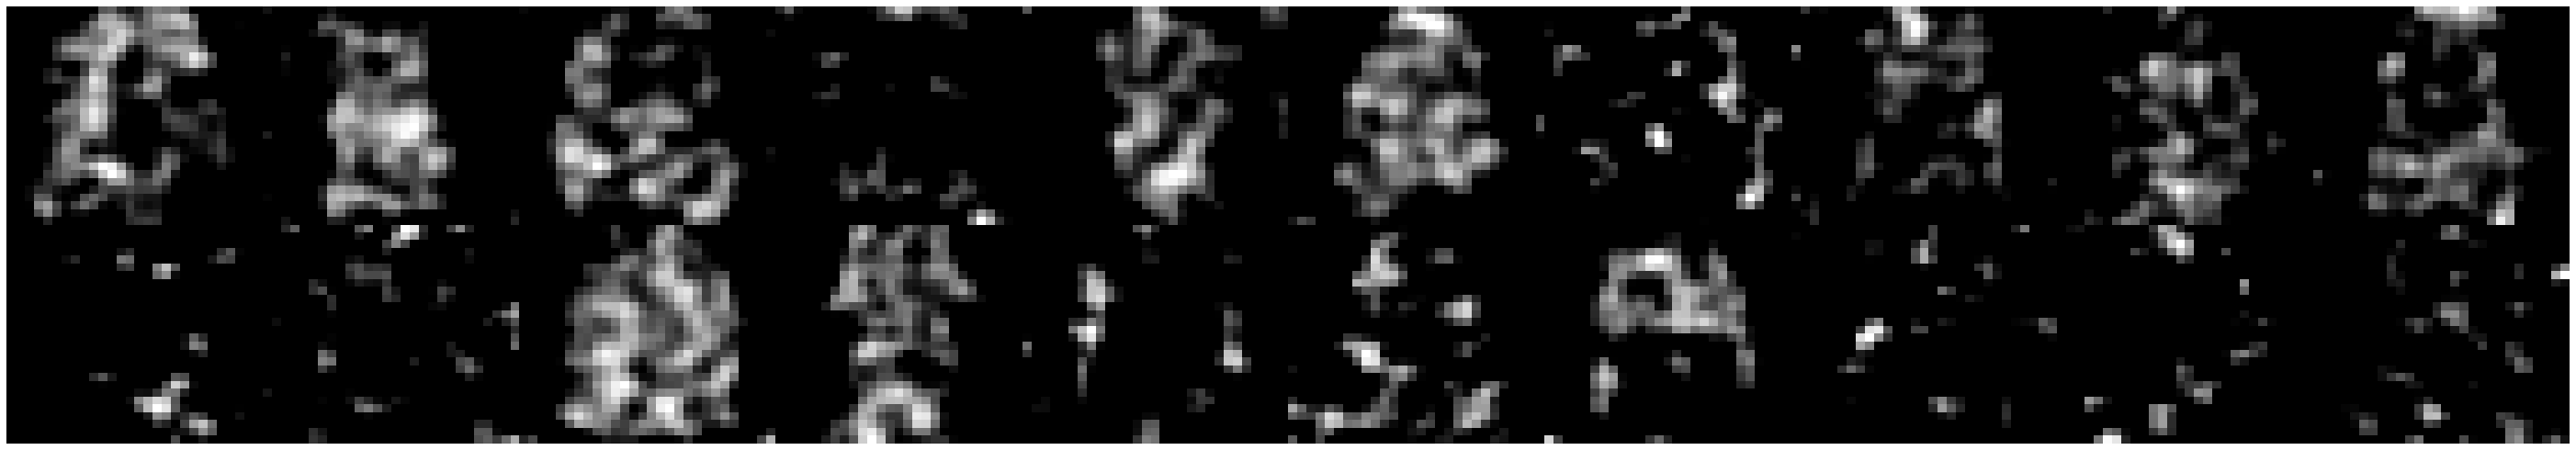

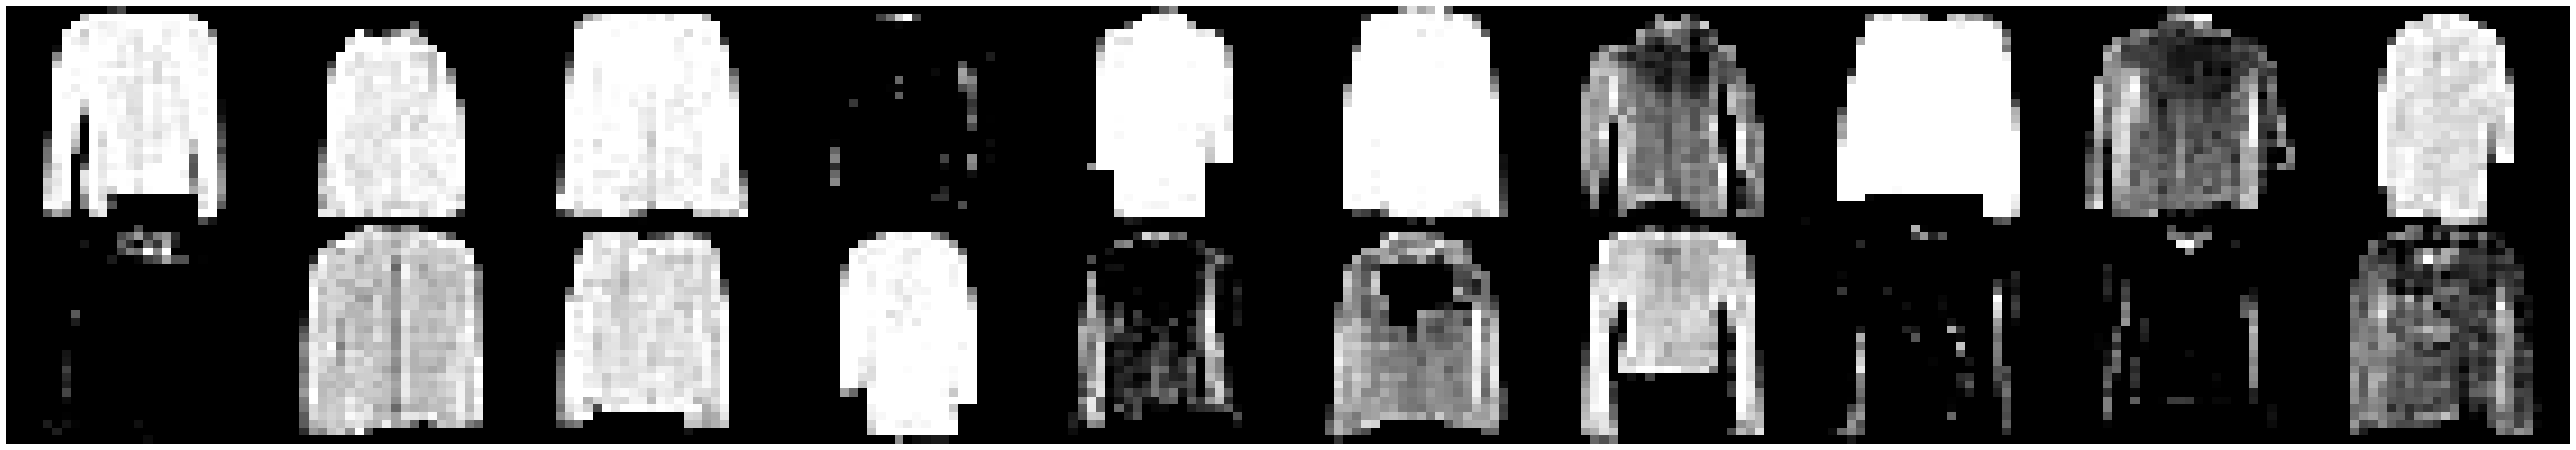

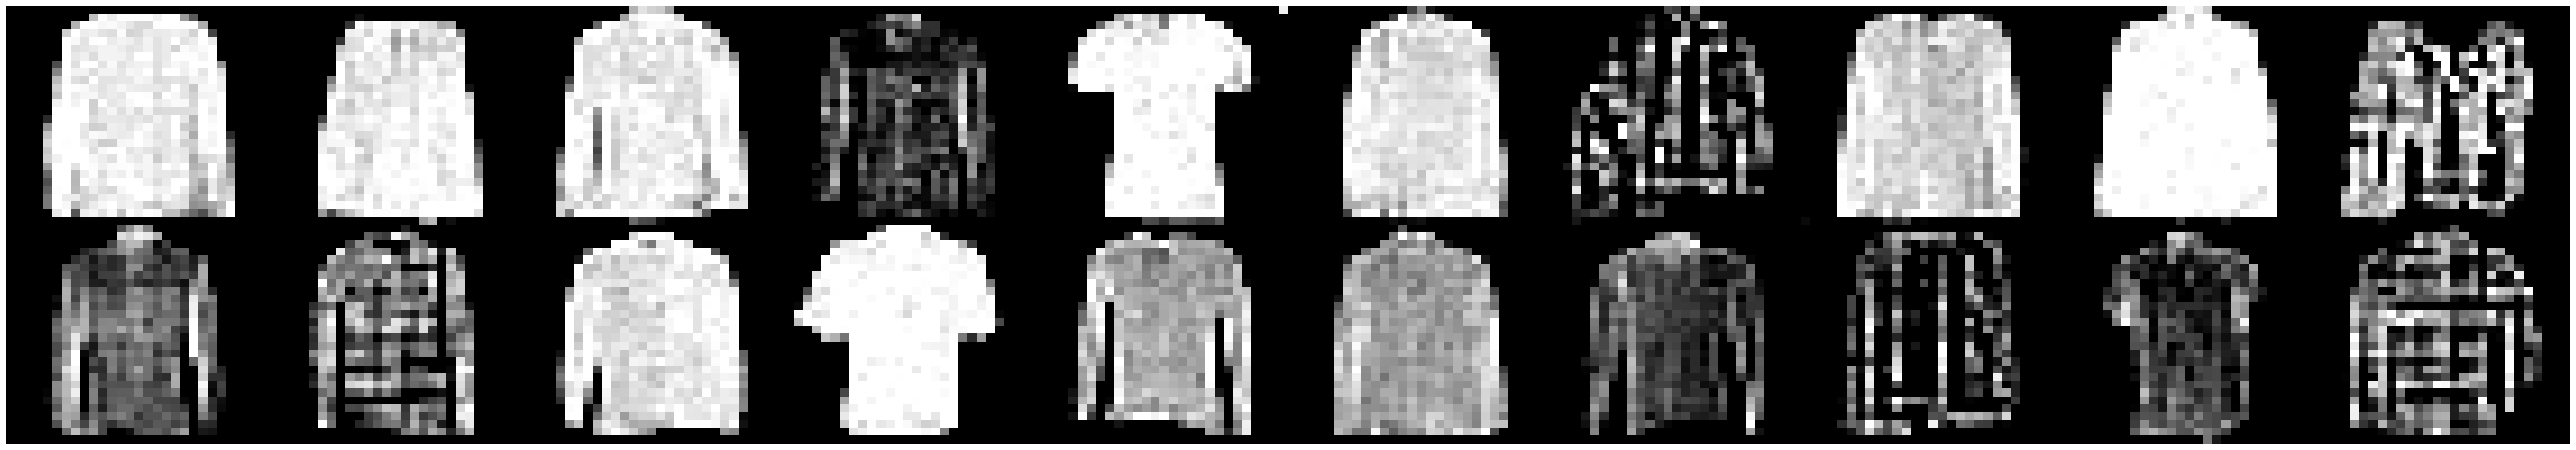

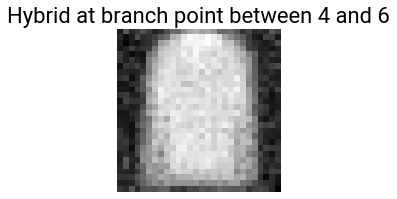

Branch point between 5 and 7


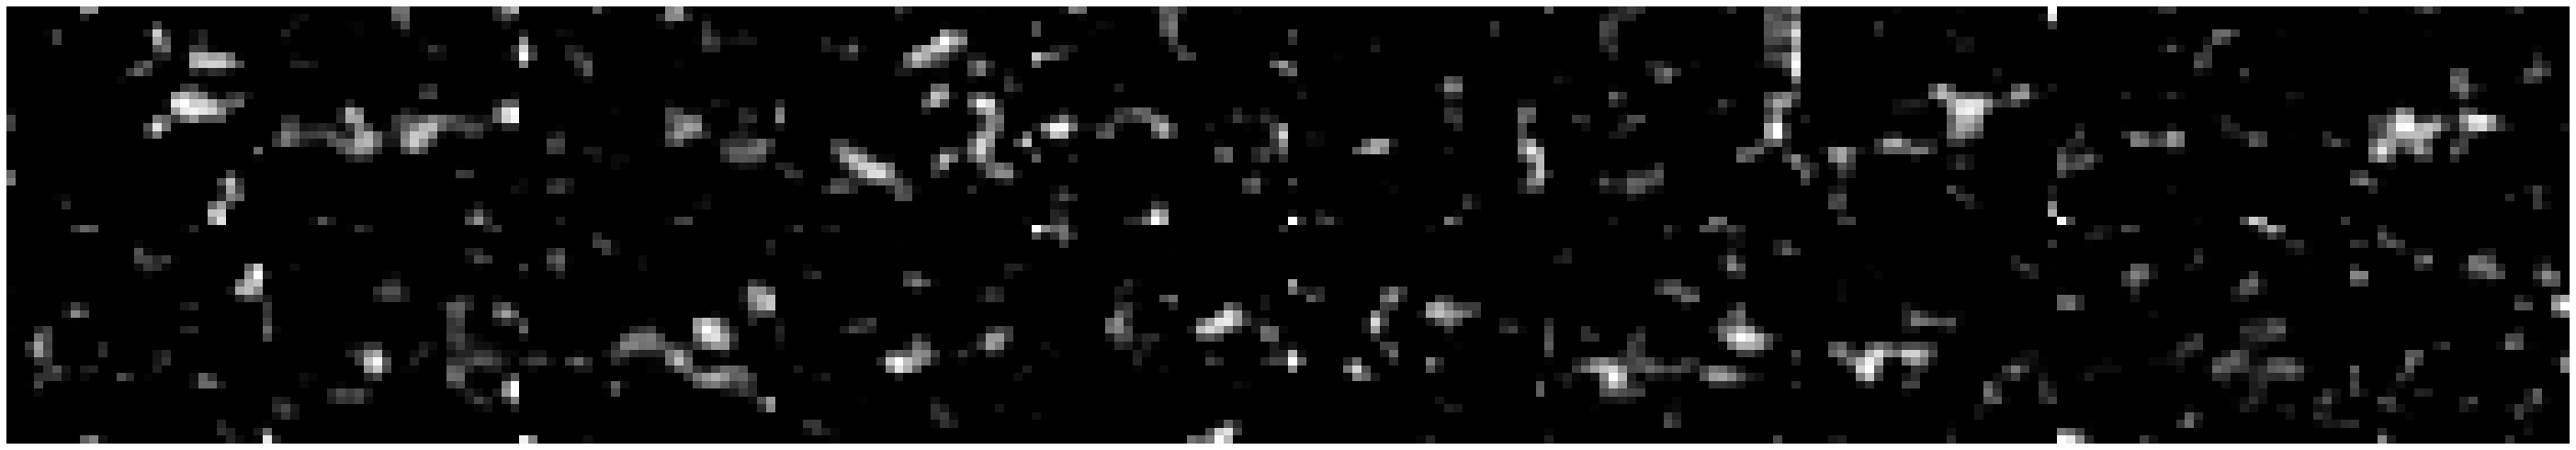

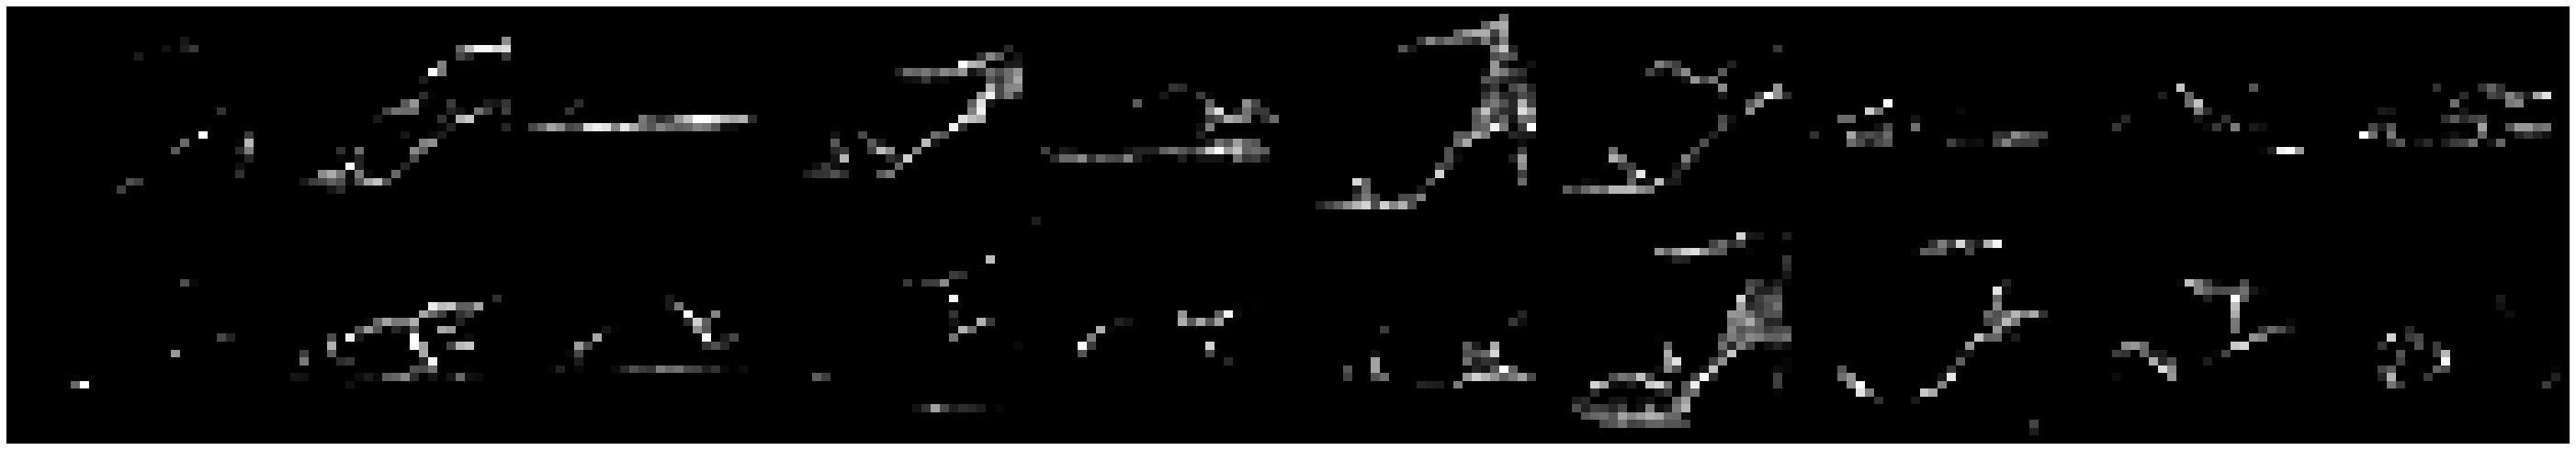

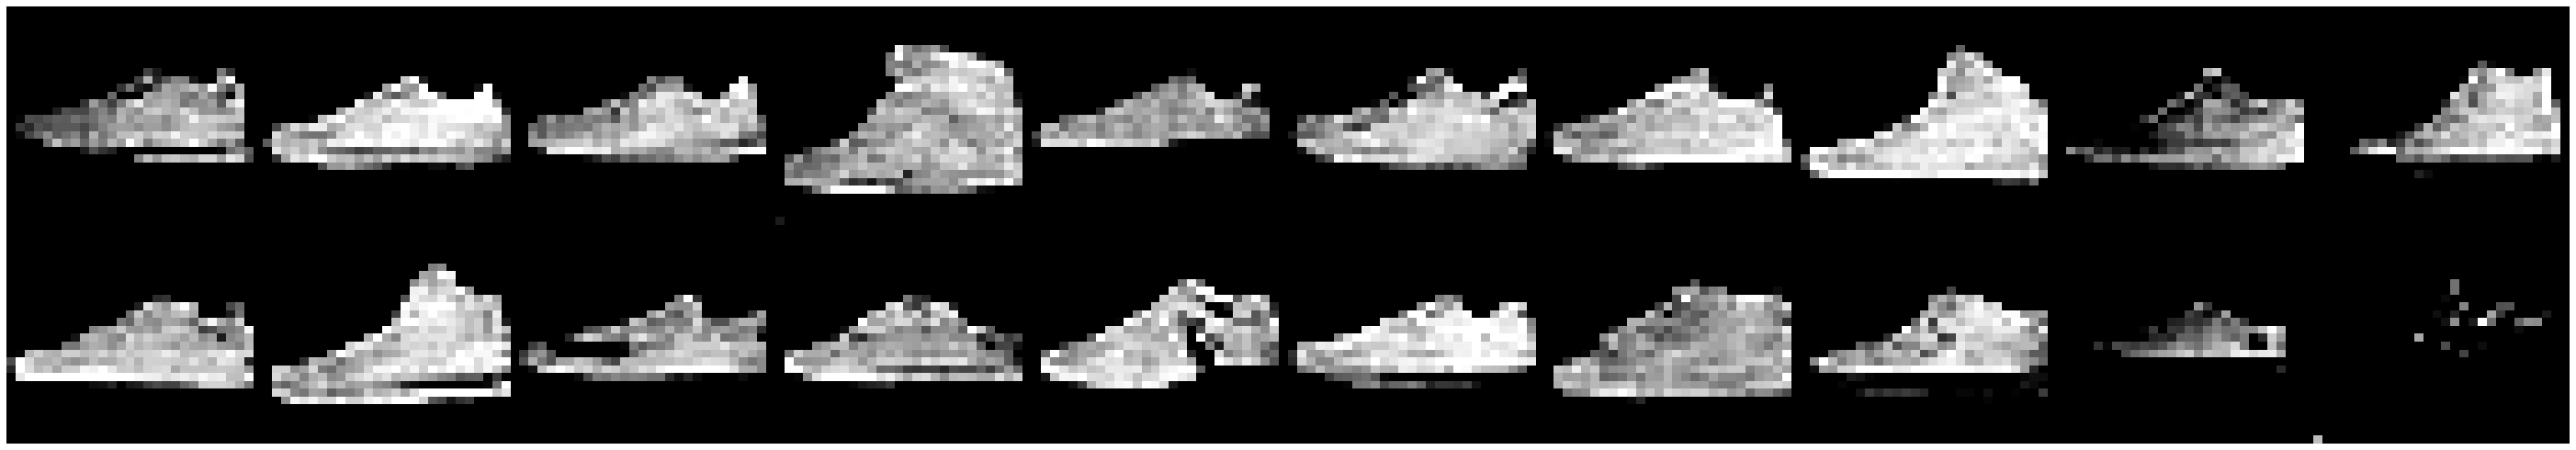

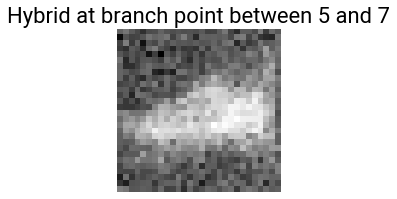

In [14]:
for class_1, class_2, branch_time in branch_point_examples:
    print("Branch point between %d and %d" % (class_1, class_2))
    samples_12 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc", t_start=branch_time,
        t_limit=t_limit, num_samples=500
    ).cpu().numpy()
    samples_1 = generate.generate_continuous_branched_samples(
        model, sde, class_1, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time,
        initial_samples=torch.tensor(samples_12).to(DEVICE), num_samples=500
    ).cpu().numpy()
    samples_2 = generate.generate_continuous_branched_samples(
        model, sde, class_2, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time,
        initial_samples=torch.tensor(samples_12).to(DEVICE), num_samples=500
    ).cpu().numpy()

    smoothed_samples_12 = np.empty_like(samples_12)
    for i in range(len(samples_12)):
        smoothed_samples_12[i, 0] = scipy.ndimage.gaussian_filter(samples_12[i, 0], sigma=1)

    fig = plot_mnist_digits(smoothed_samples_12, grid_size=(10, 2), scale=5)
    fig.savefig(
        os.path.join(out_path, "fmnist_hybrid_%d_%d.svg" % (class_1, class_2)),
        format="svg"
    )
    fig = plot_mnist_digits(samples_1, grid_size=(10, 2), scale=5)
    fig.savefig(
        os.path.join(out_path, "fmnist_hybrid_%d.svg" % class_1),
        format="svg"
    )
    fig = plot_mnist_digits(samples_2, grid_size=(10, 2), scale=5)
    fig.savefig(
        os.path.join(out_path, "fmnist_hybrid_%d.svg" % class_2),
        format="svg"
    )
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(np.mean(samples_12, axis=(0, 1)), cmap="Greys_r")
    ax.axis("off")
    ax.set_title("Hybrid at branch point between %d and %d" % (class_1, class_2))
    fig.savefig(
        os.path.join(out_path, "fmnist_hybrid_average_%d_%d.svg" % (class_1, class_2)),
        format="svg"
    )
    plt.show()

### Transmutation

Class 4 to 6
Class 6 to 4
Class 5 to 7
Class 7 to 5


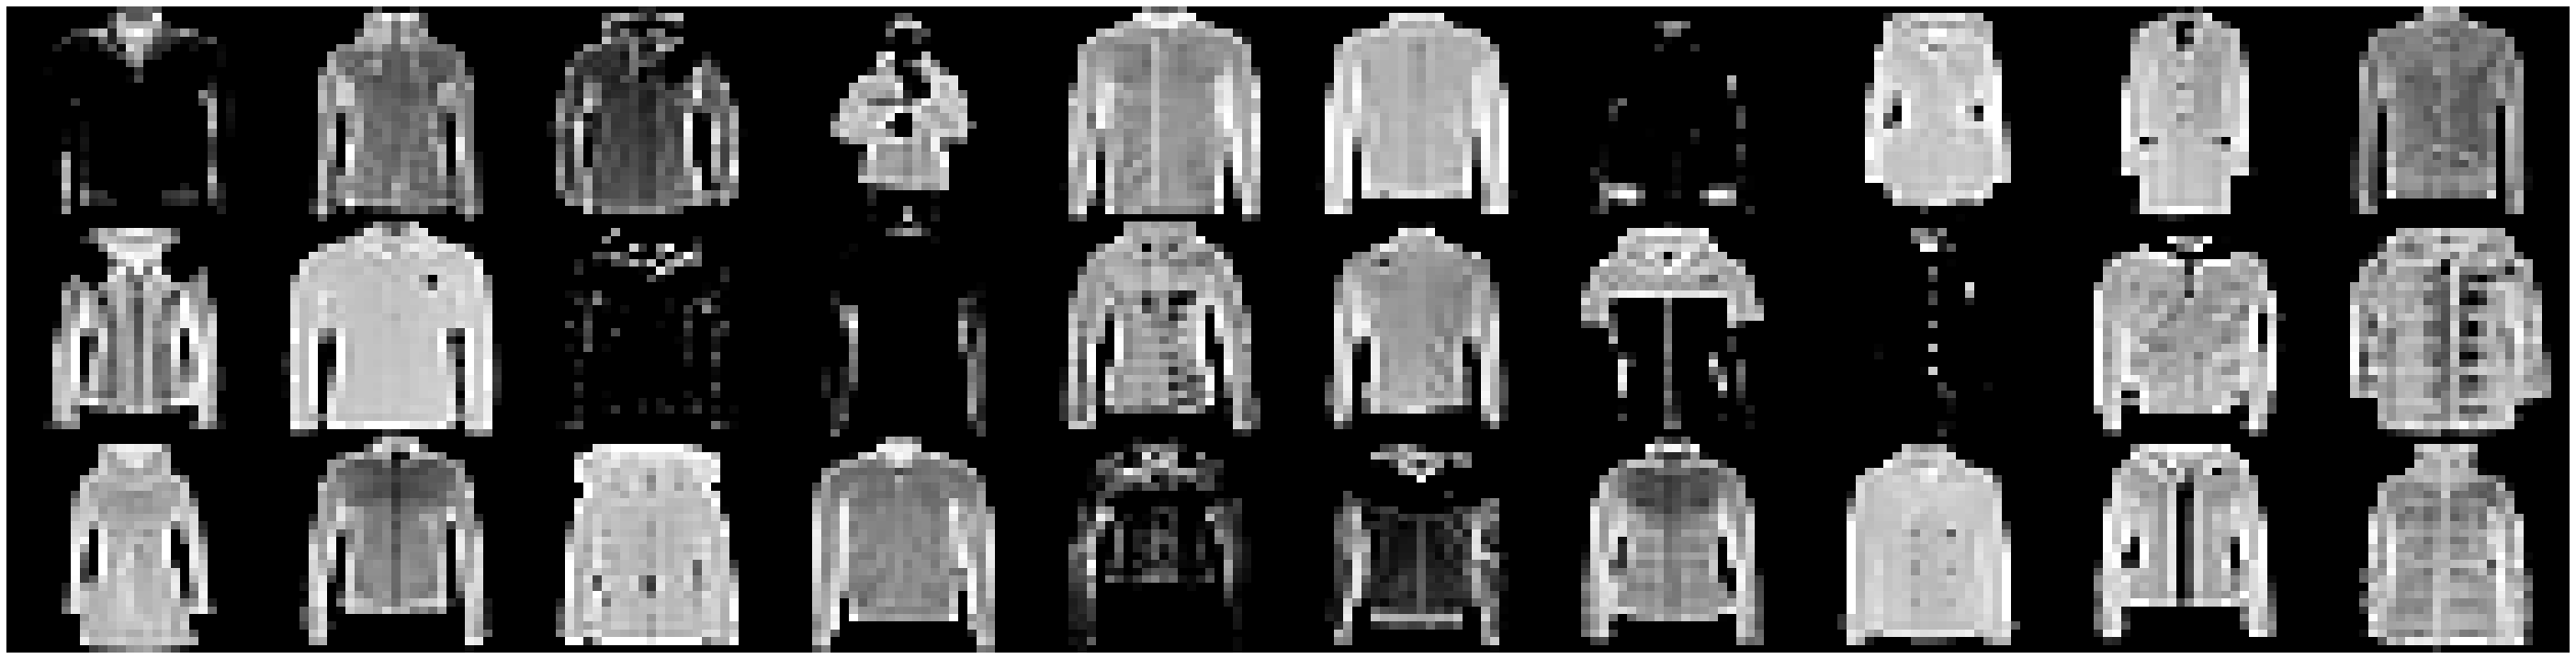

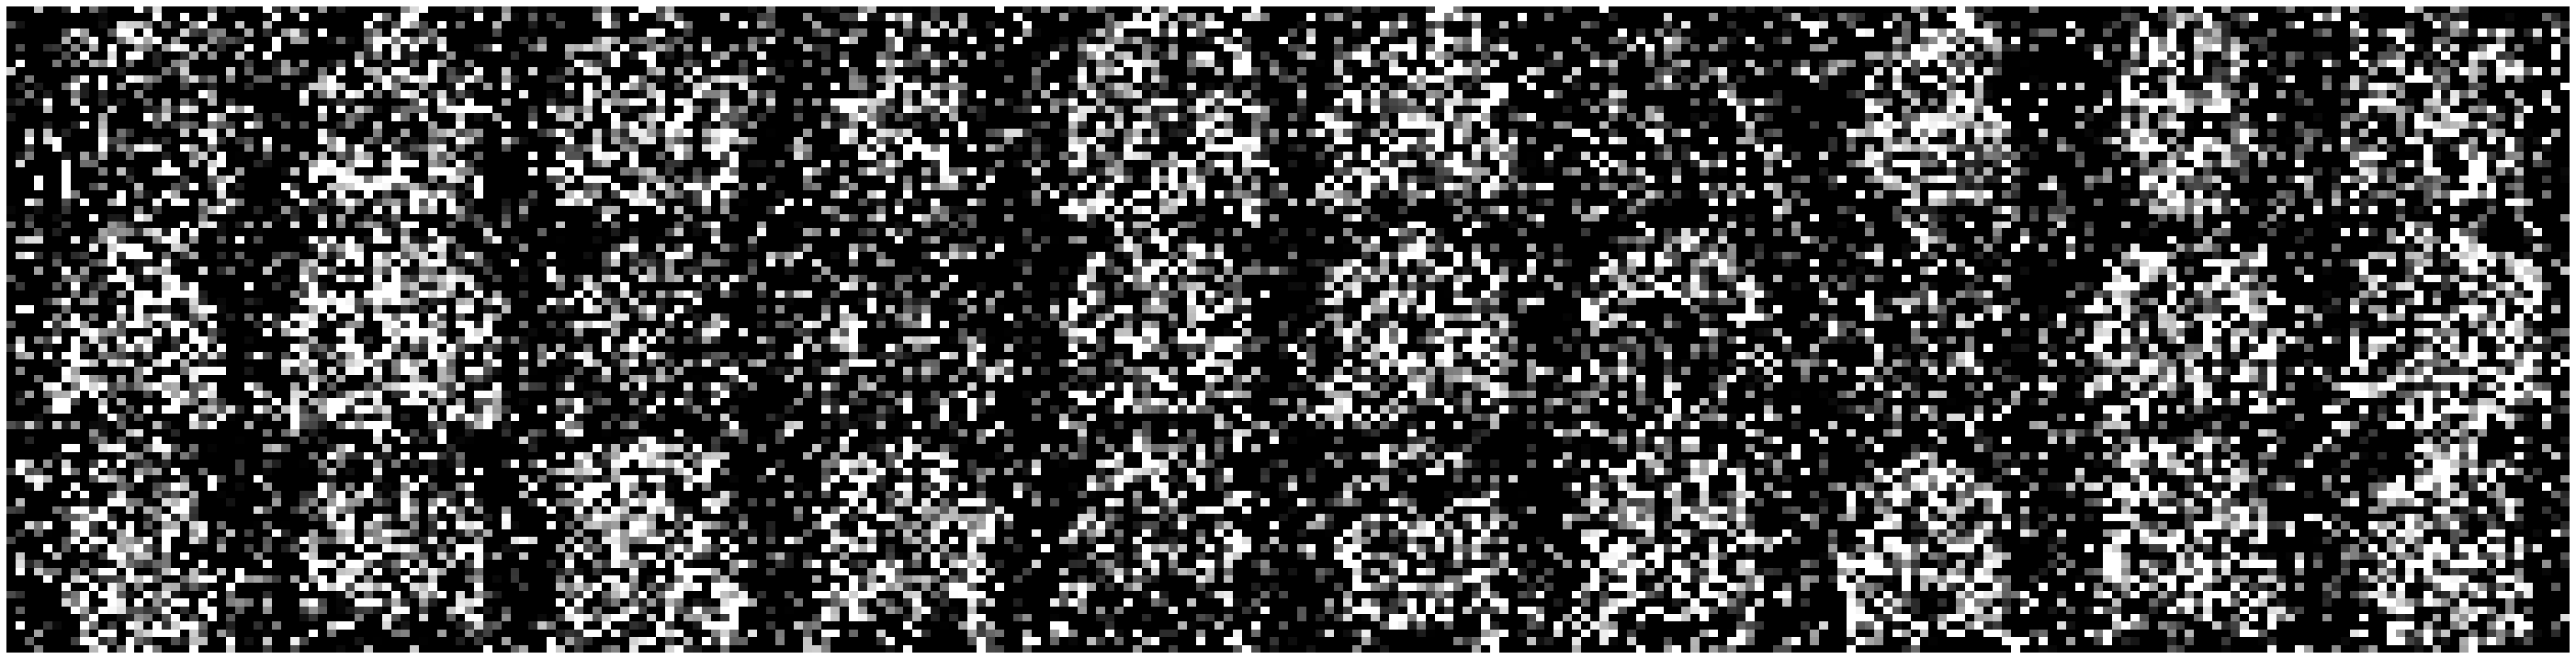

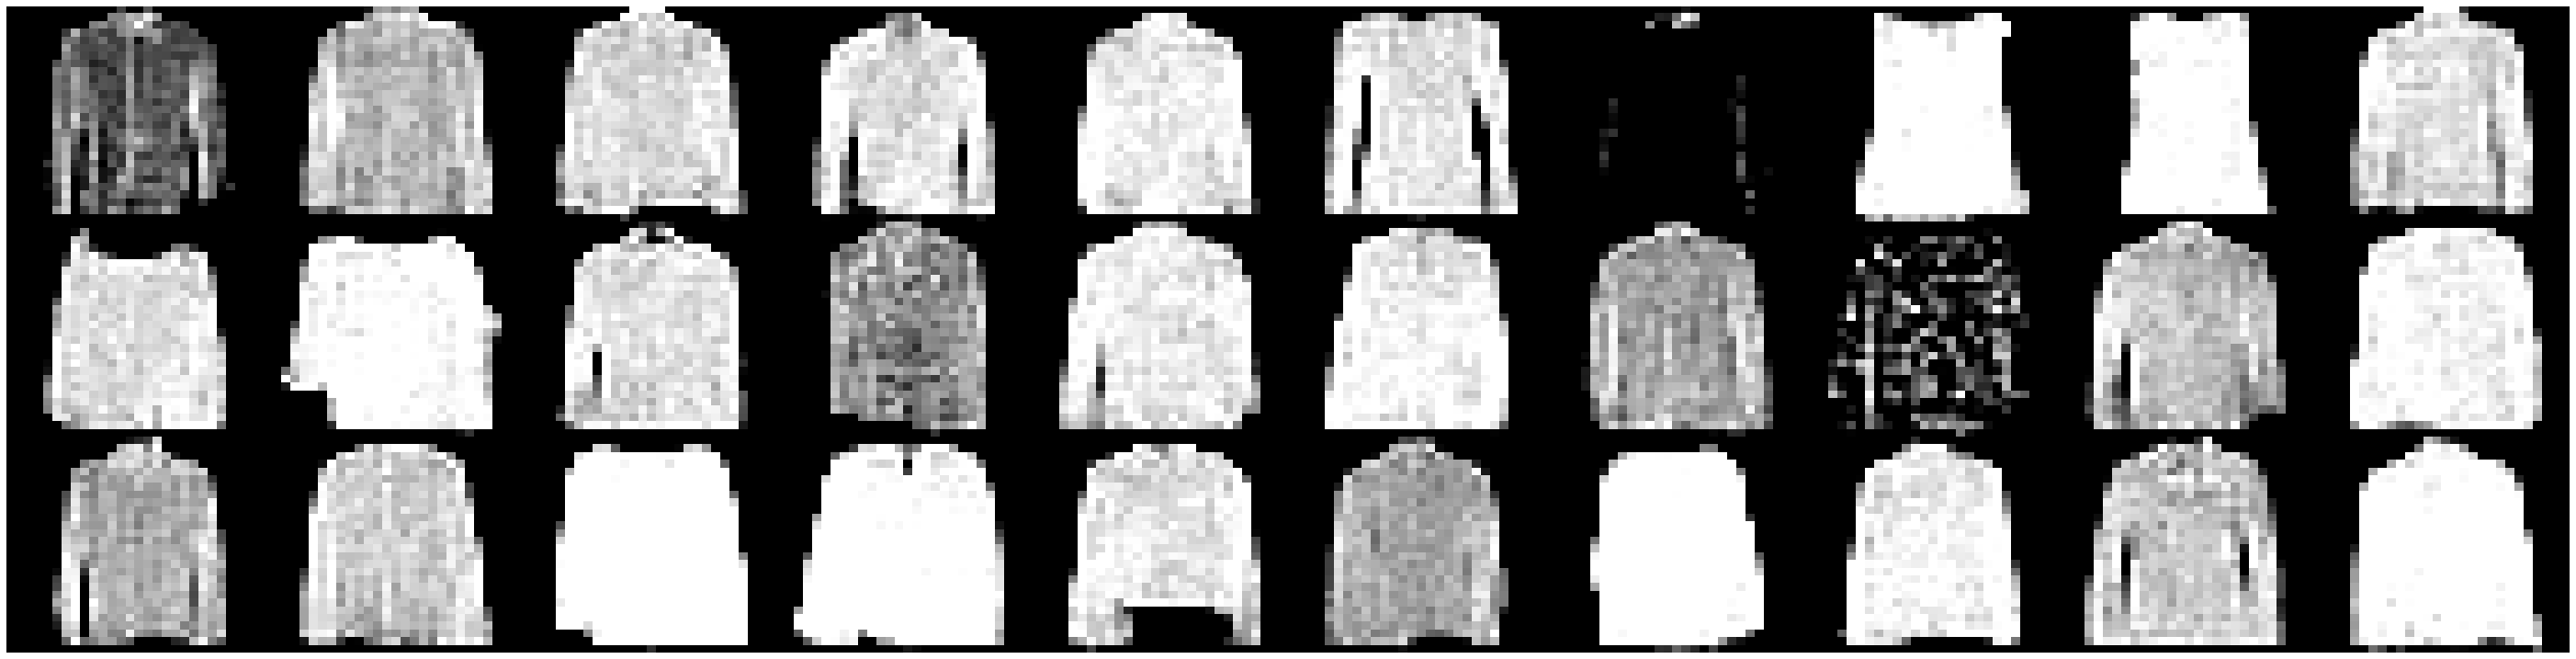

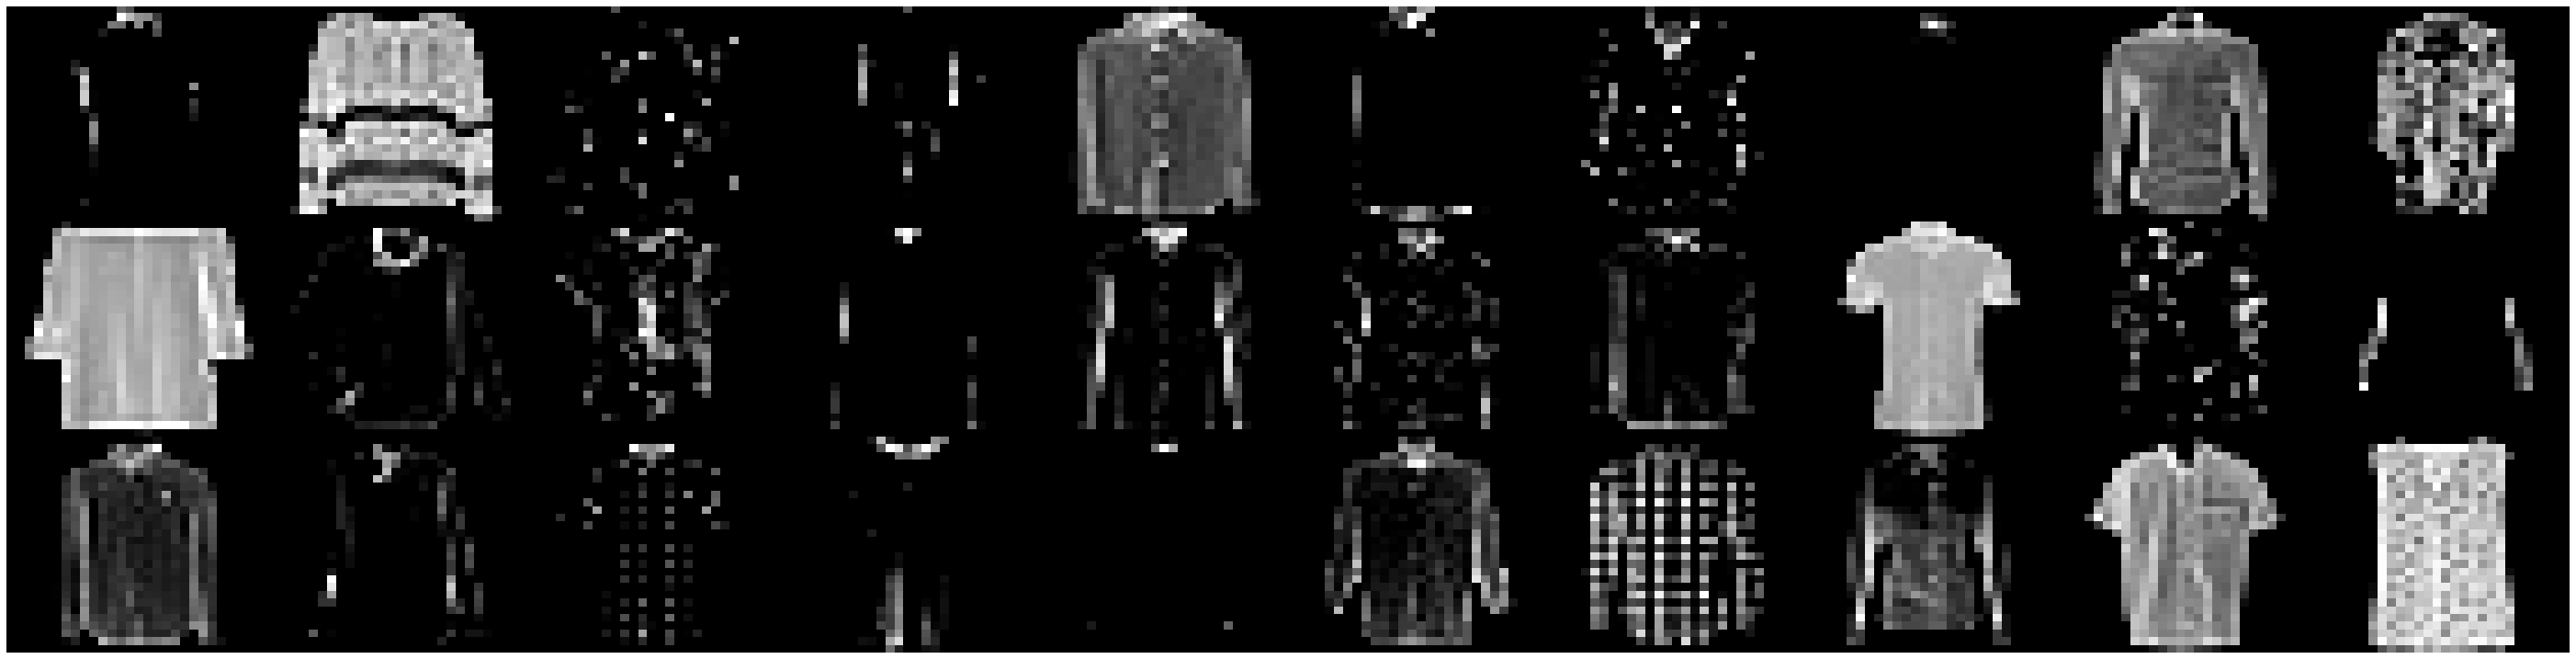

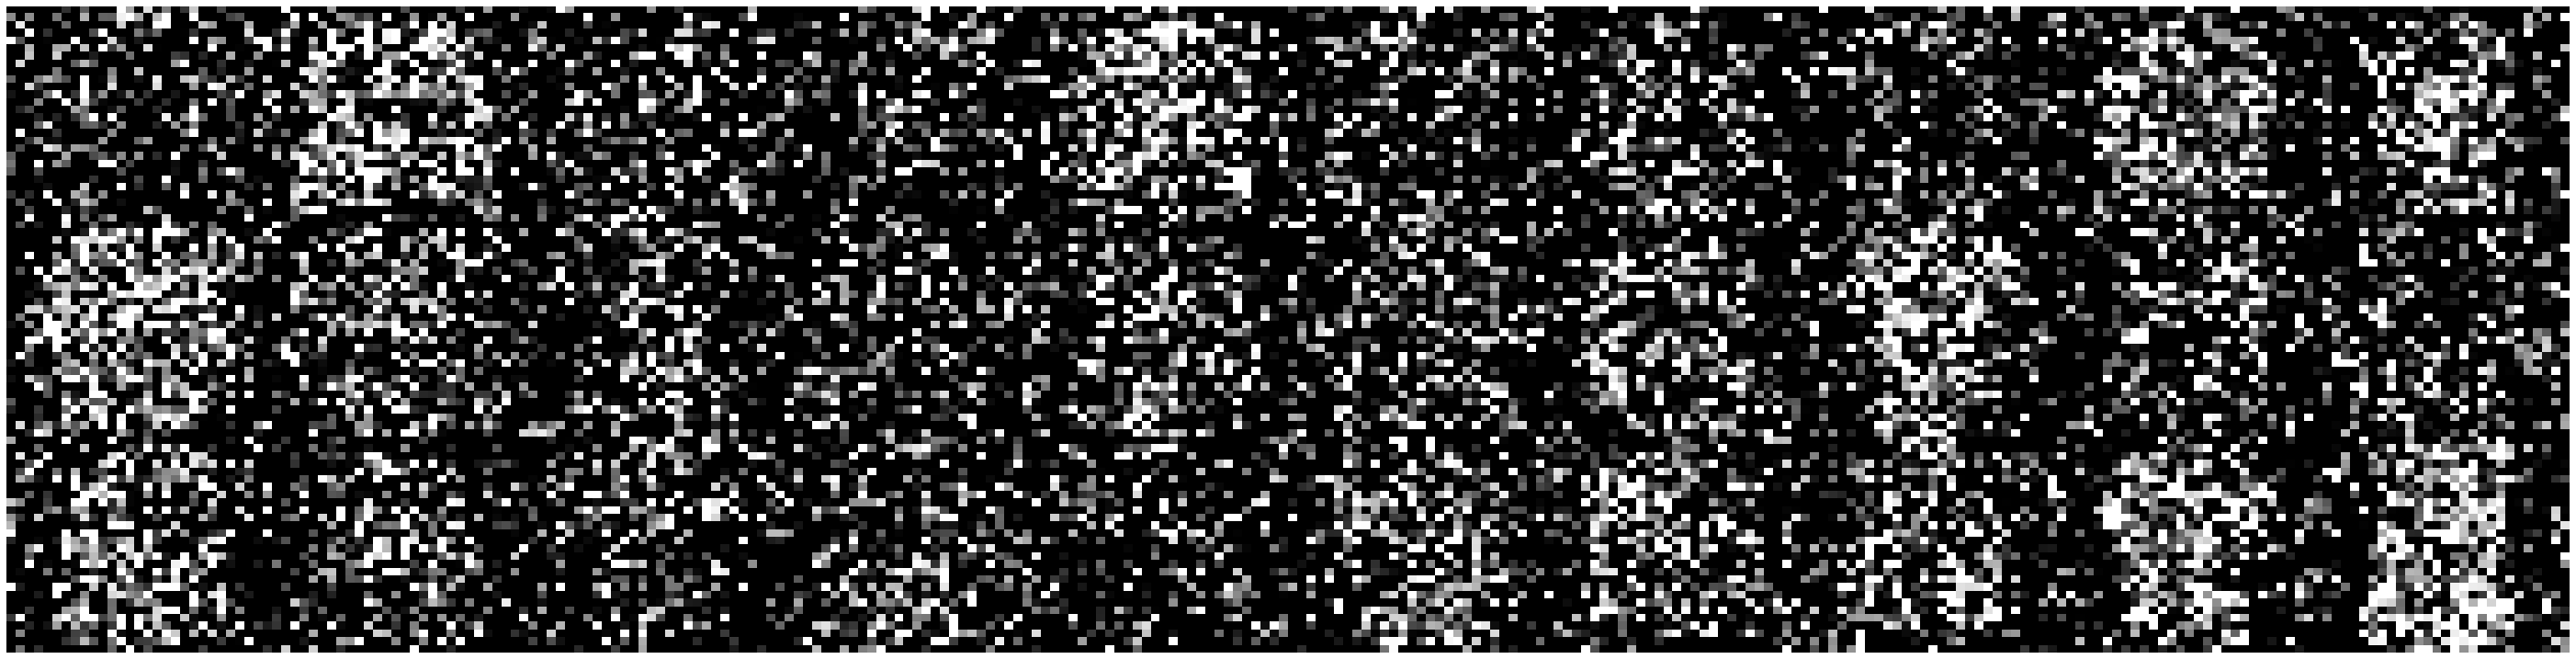

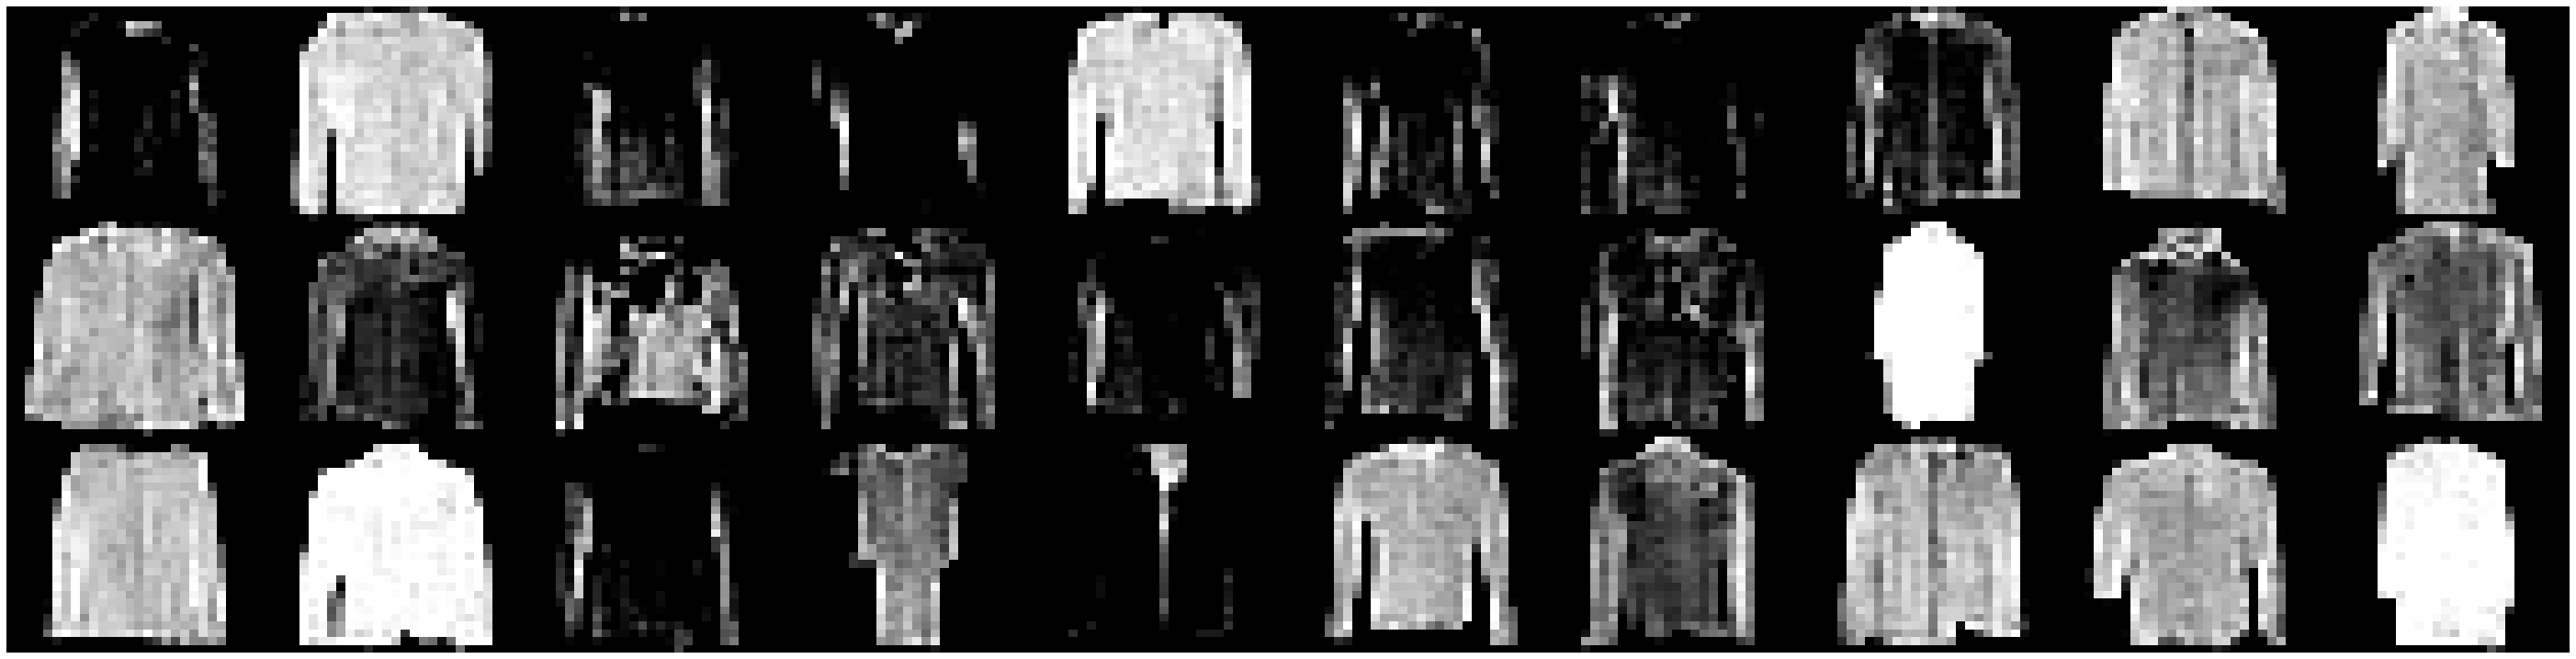

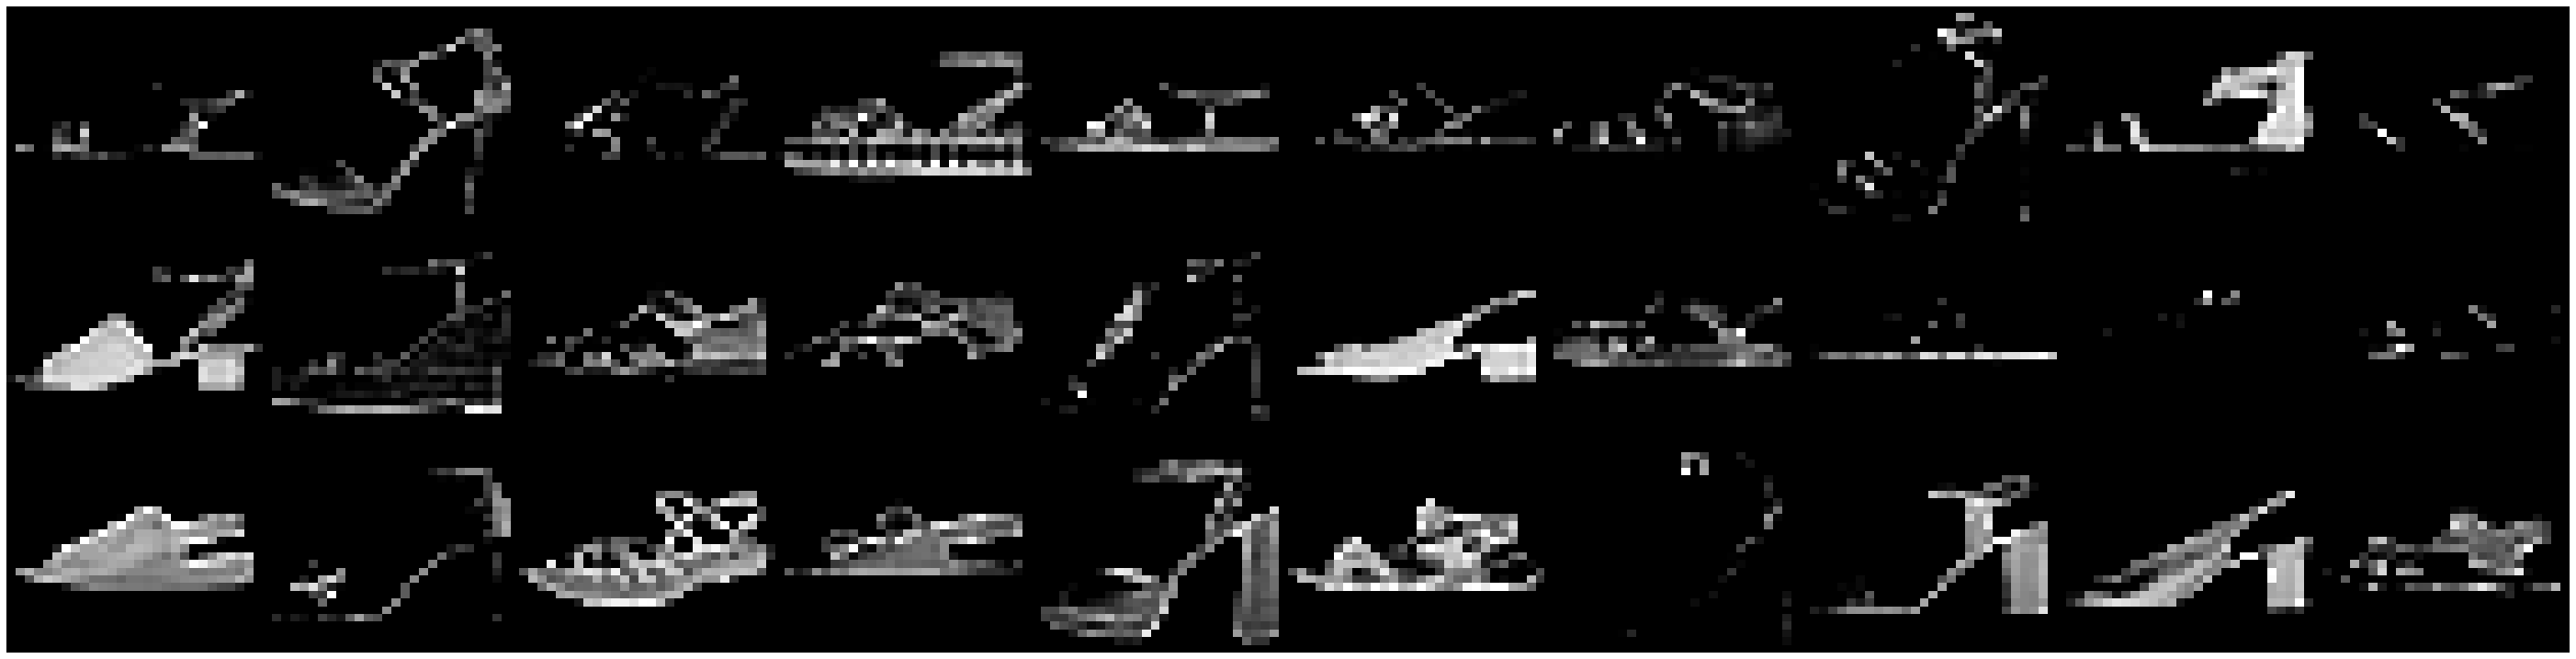

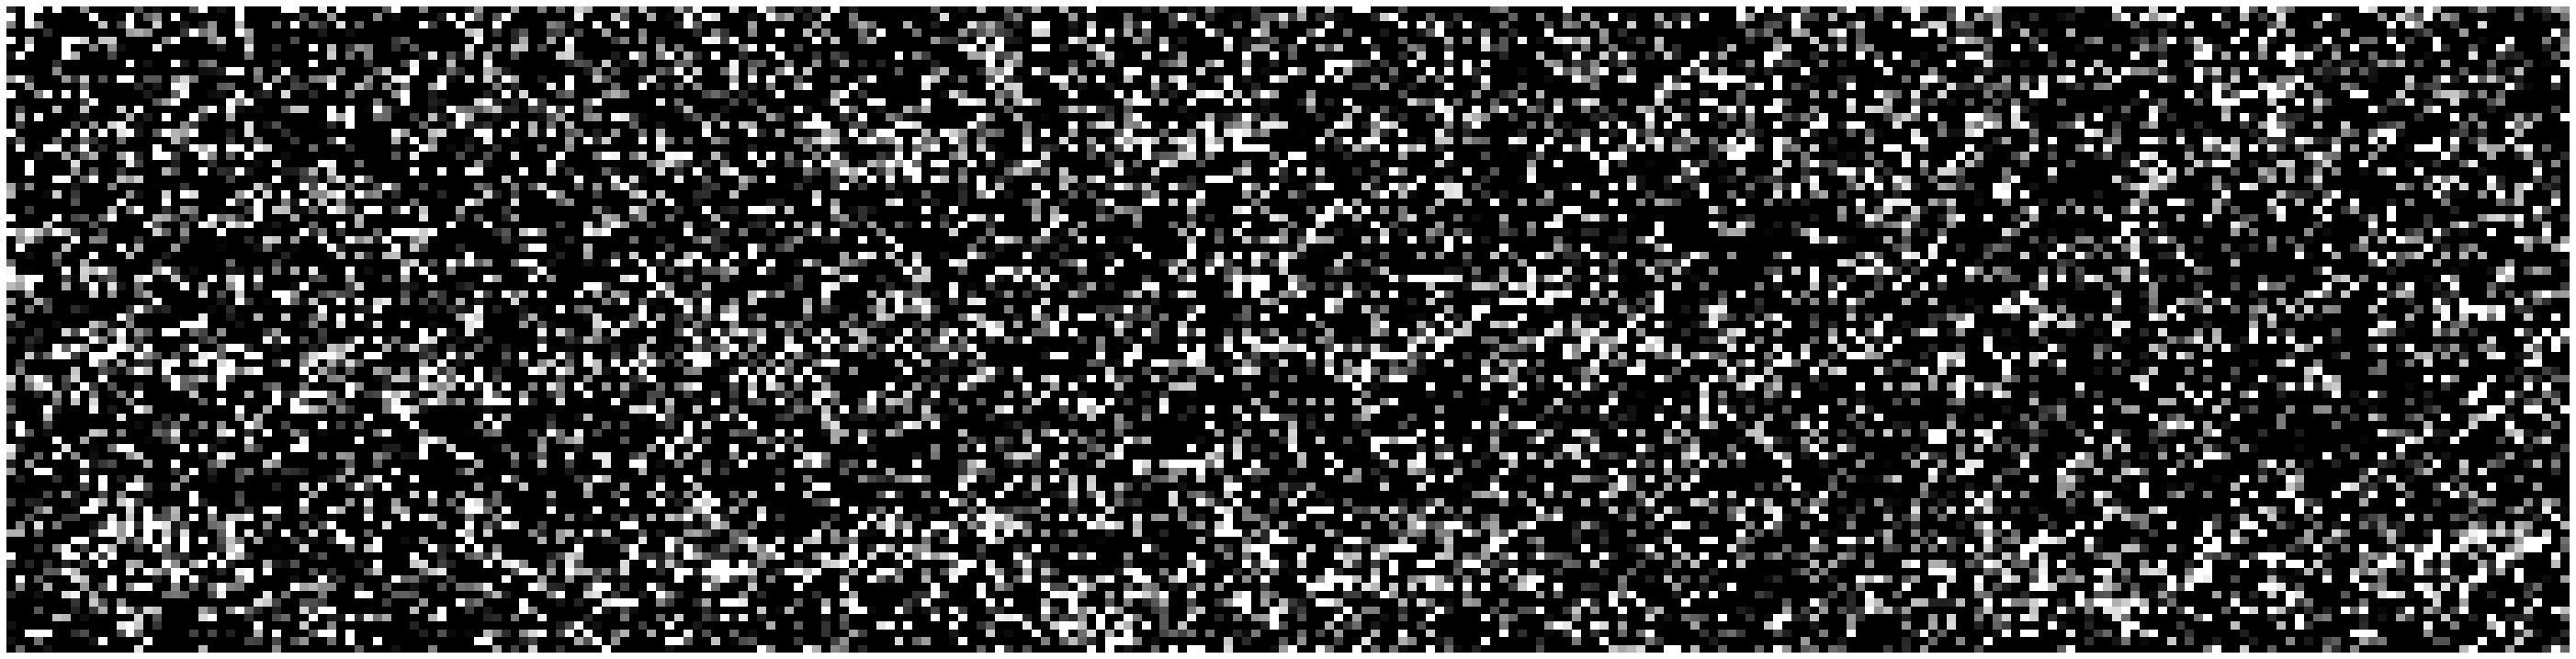

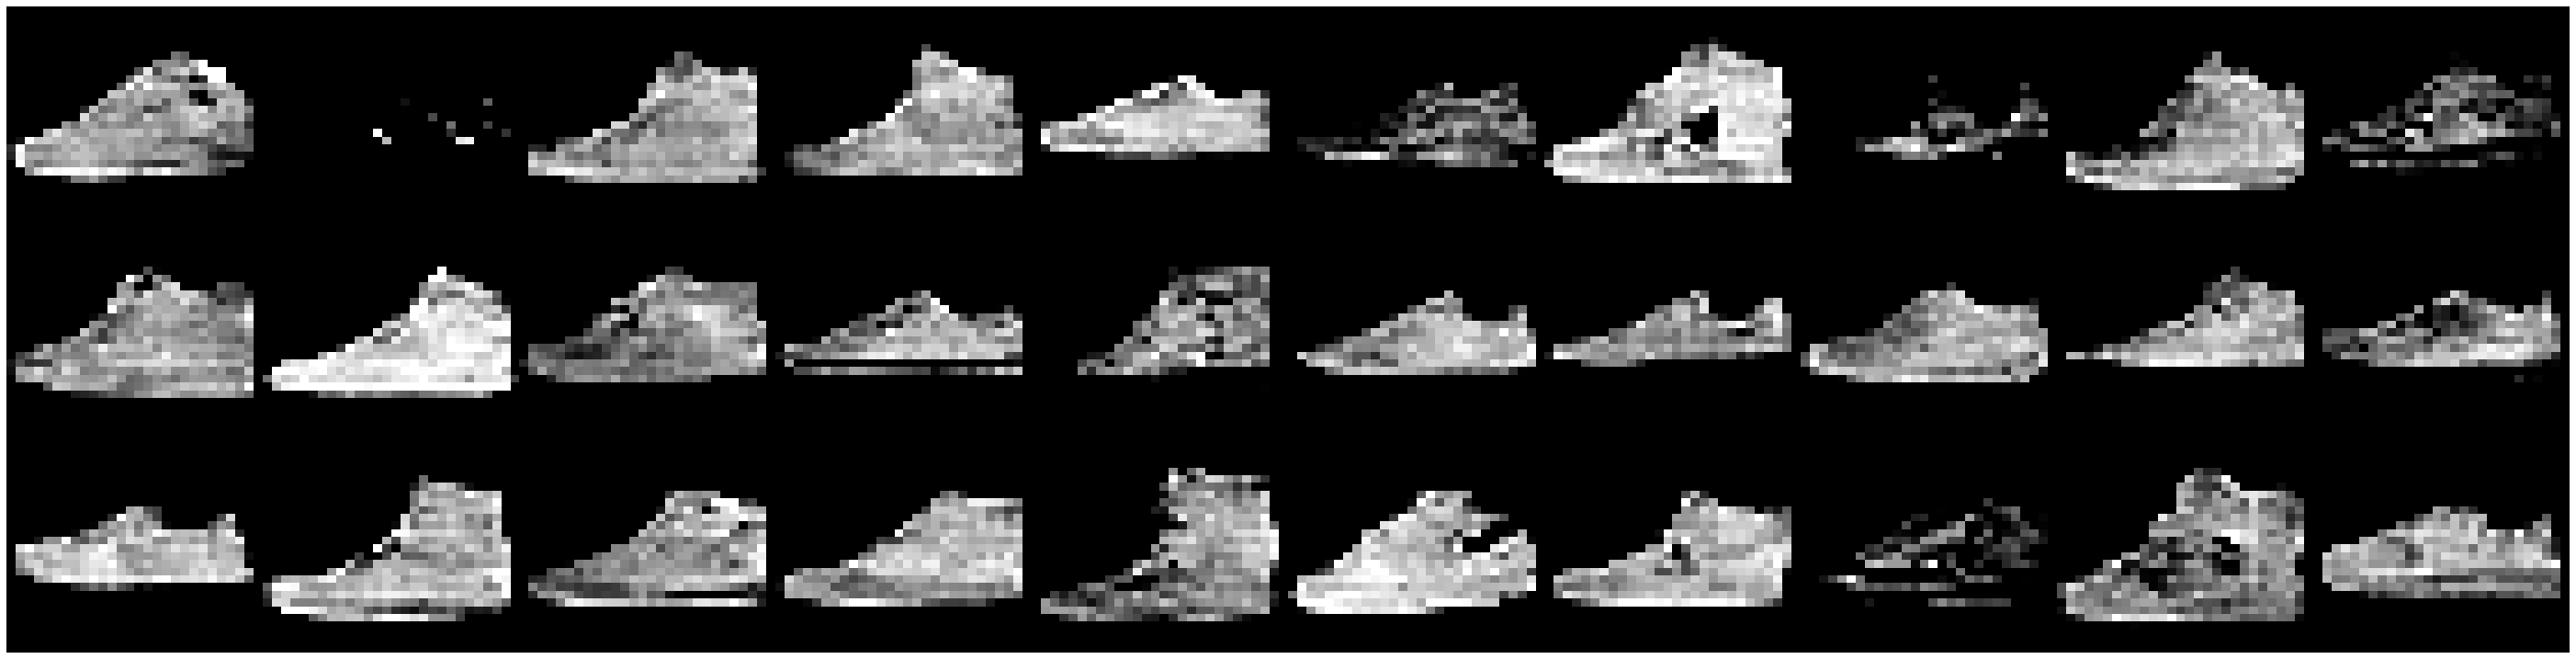

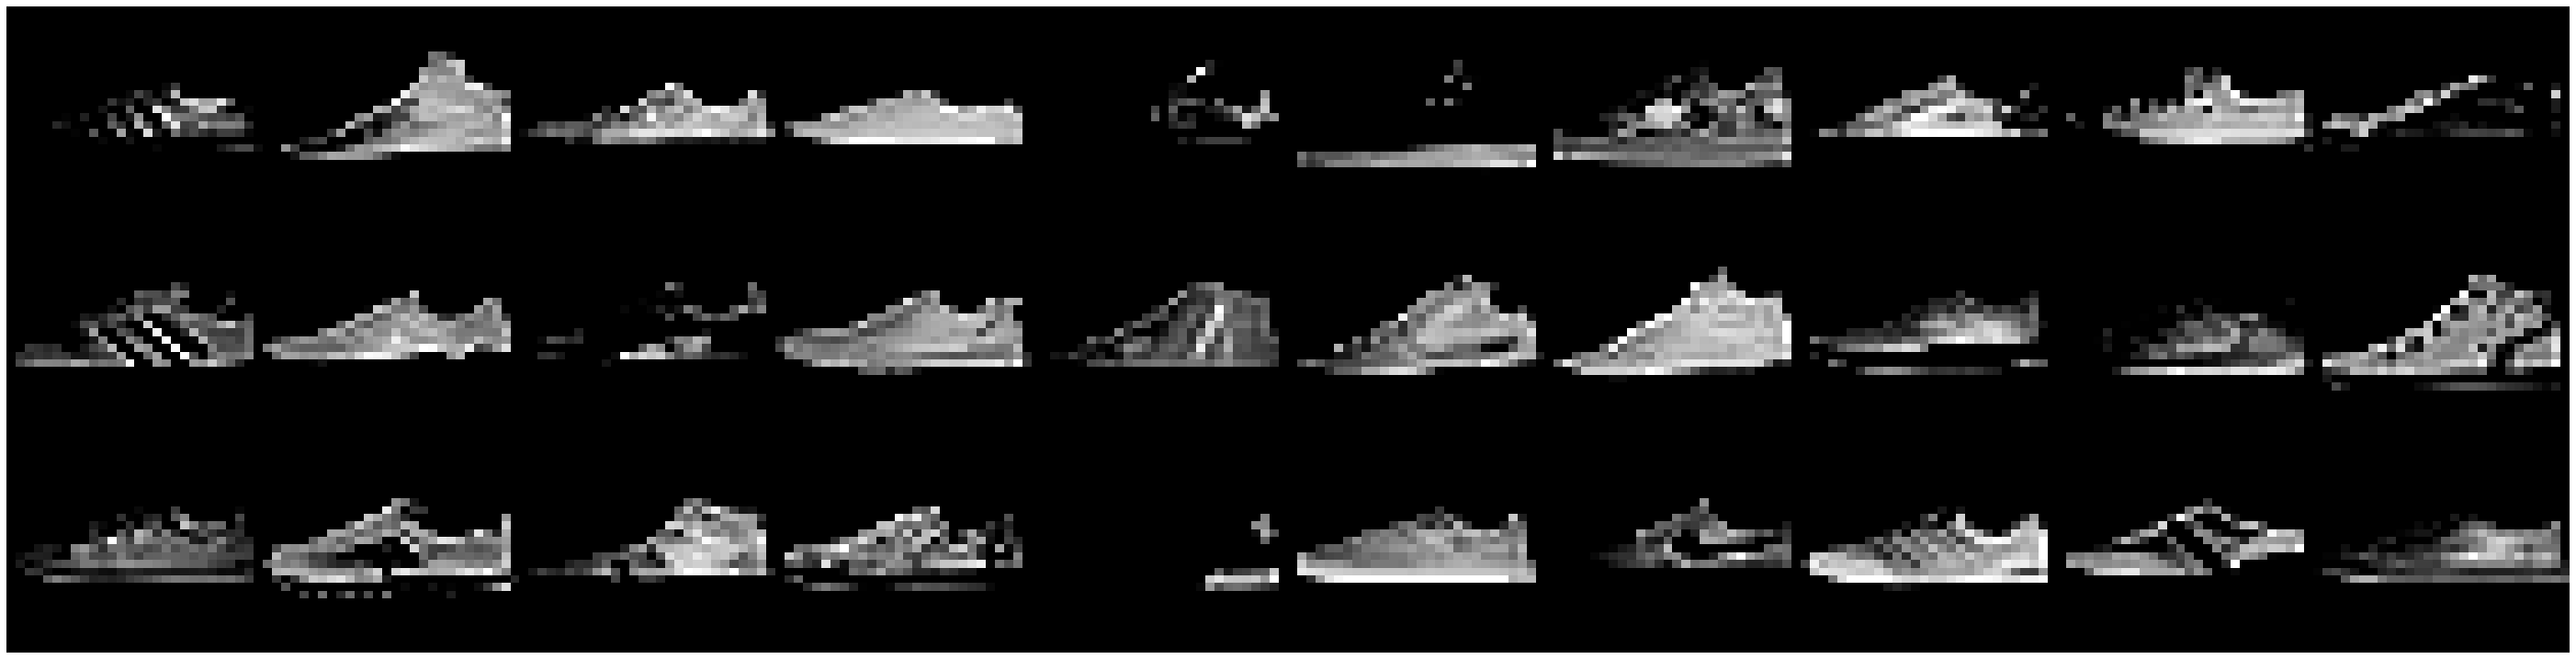

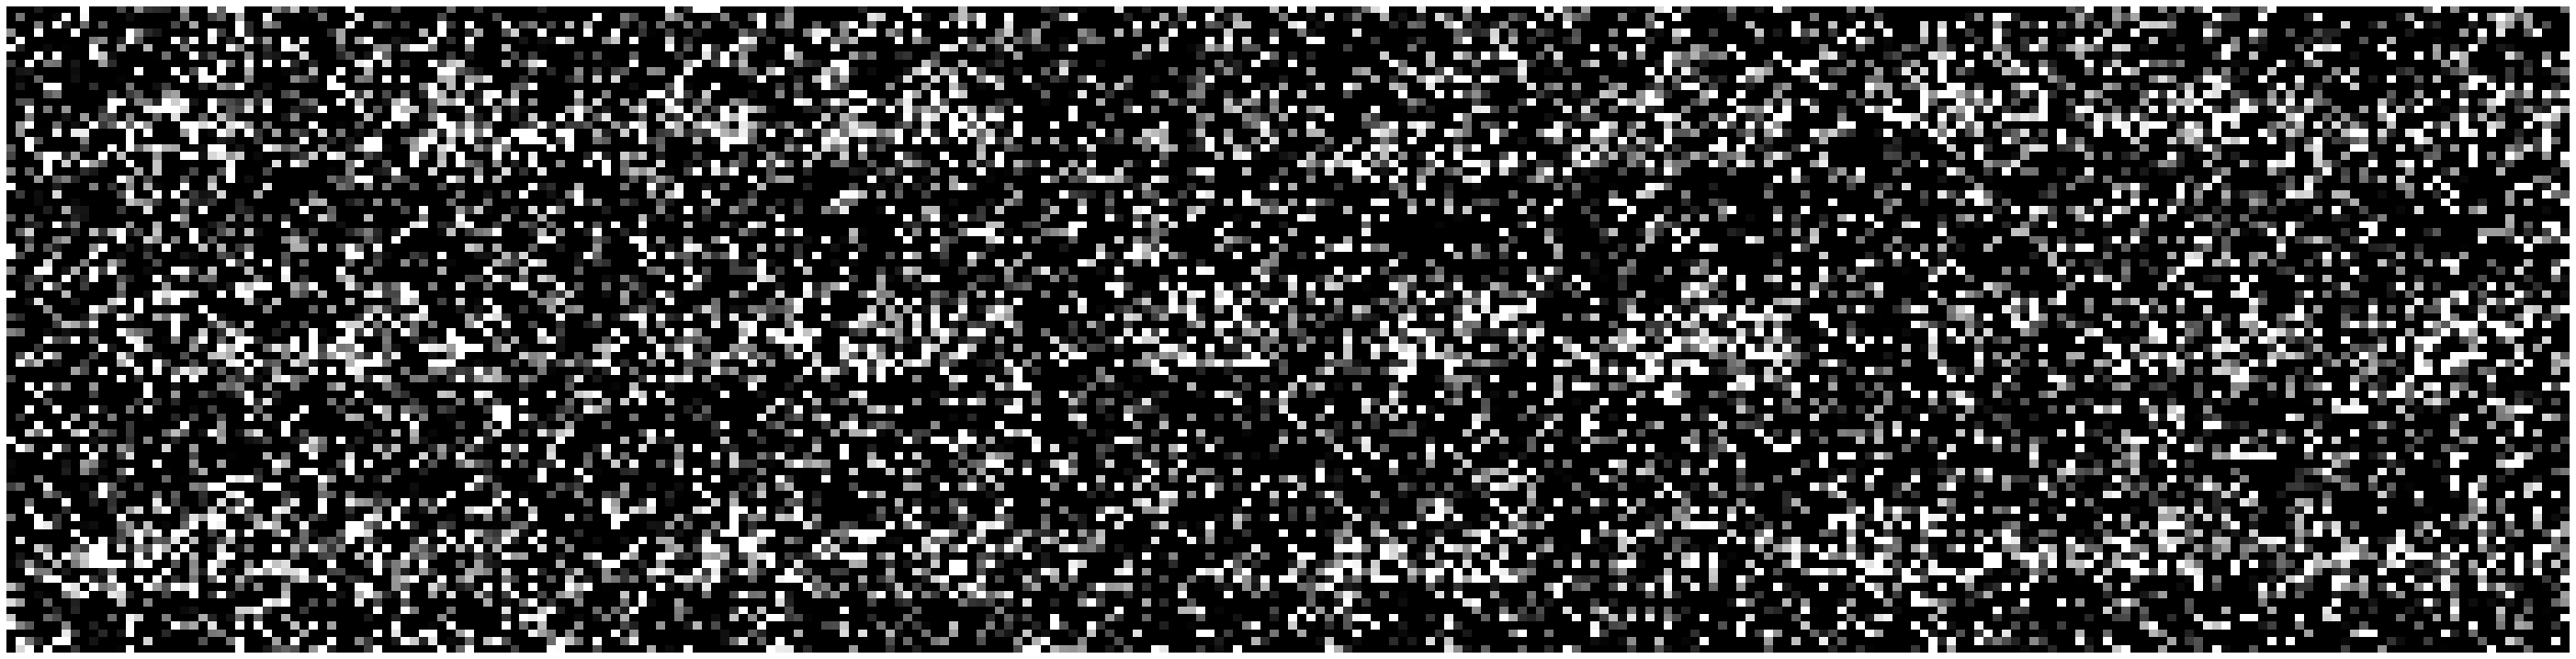

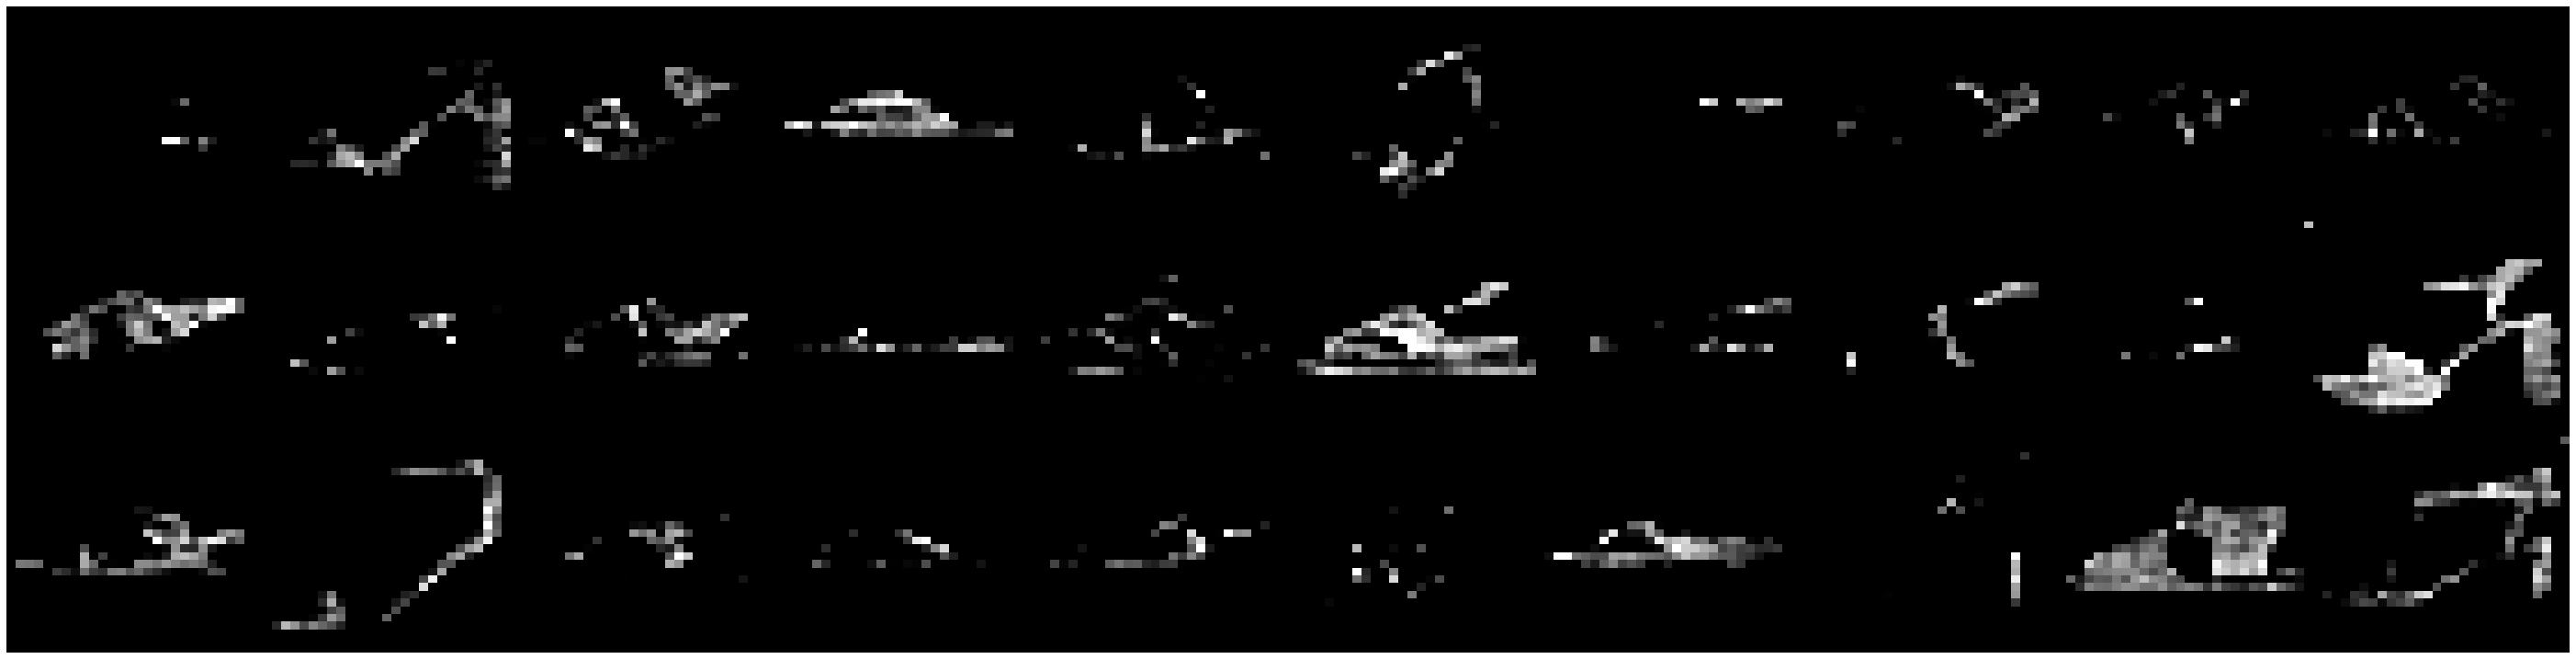

In [16]:
for class_1, class_2, branch_time in branch_point_examples:
    orig_1 = torch.stack([
        torch.tensor(dataset[i][0], device=DEVICE) for i in 
        np.random.choice(np.where(dataset.targets == class_1)[0], size=256, replace=False)
    ])
    orig_2 = torch.stack([
        torch.tensor(dataset[i][0], device=DEVICE) for i in 
        np.random.choice(np.where(dataset.targets == class_2)[0], size=256, replace=False)
    ])

    # Perform forward diffusion
    time_steps = 10
    all_t = np.linspace(0, branch_time, time_steps)
    forward_1_to_2 = np.empty((len(all_t),) + orig_1.shape)
    backward_1_to_2 = np.empty((len(all_t) - 1,) + orig_1.shape)
    forward_2_to_1 = np.empty((len(all_t),) + orig_1.shape)
    backward_2_to_1 = np.empty((len(all_t) - 1,) + orig_1.shape)
    for t_i, t in enumerate(all_t):
        forward_1_to_2[t_i] = sde.forward(
            orig_1, torch.ones(len(orig_1)).to(DEVICE) * t
        )[0].cpu().numpy()
        forward_2_to_1[t_i] = sde.forward(
            orig_2, torch.ones(len(orig_2)).to(DEVICE) * t
        )[0].cpu().numpy()

    # Perform backward diffusion
    all_t_flip = np.flip(all_t)
    last_1_to_2 = torch.tensor(forward_1_to_2[-1]).to(DEVICE).float()
    last_2_to_1 = torch.tensor(forward_2_to_1[-1]).to(DEVICE).float()
    for t_i in range(len(all_t_flip) - 1):
        last_1_to_2 = generate.generate_continuous_branched_samples(
            model, sde, class_2, class_time_to_branch_tensor, sampler="pc",
            t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
            num_samples=orig_1.shape[0], initial_samples=last_1_to_2,
            num_steps=50
        )
        backward_1_to_2[t_i] = last_1_to_2.cpu().numpy()

        last_2_to_1 = generate.generate_continuous_branched_samples(
            model, sde, class_1, class_time_to_branch_tensor, sampler="pc",
            t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
            num_samples=orig_2.shape[0], initial_samples=last_2_to_1,
            num_steps=50
        )
        backward_2_to_1[t_i] = last_2_to_1.cpu().numpy()

    print("Class %d to %d" % (class_1, class_2))
    plot_inds = np.arange(0, len(orig_1), len(orig_1) // 30)
    fig = plot_mnist_digits(forward_1_to_2[0][plot_inds], grid_size=(10, 3), scale=5)
    fig.savefig(
        os.path.join(out_path, "fmnist_transmutation_%d_to_%d_before.svg" % (class_1, class_2)),
        format="svg"
    )
    fig = plot_mnist_digits(forward_1_to_2[-1][plot_inds], grid_size=(10, 3), scale=5)
    fig.savefig(
        os.path.join(out_path, "fmnist_transmutation_%d_to_%d_middle.svg" % (class_1, class_2)),
        format="svg"
    )
    fig = plot_mnist_digits(backward_1_to_2[-1][plot_inds], grid_size=(10, 3), scale=5)
    fig.savefig(
        os.path.join(out_path, "fmnist_transmutation_%d_to_%d_after.svg" % (class_1, class_2)),
        format="svg"
    )

    print("Class %d to %d" % (class_2, class_1))
    plot_inds = np.arange(0, len(orig_1), len(orig_1) // 30)
    fig = plot_mnist_digits(forward_2_to_1[0][plot_inds], grid_size=(10, 3), scale=5)
    fig.savefig(
        os.path.join(out_path, "fmnist_transmutation_%d_to_%d_before.svg" % (class_2, class_1)),
        format="svg"
    )
    fig = plot_mnist_digits(forward_2_to_1[-1][plot_inds], grid_size=(10, 3), scale=5)
    fig.savefig(
        os.path.join(out_path, "fmnist_transmutation_%d_to_%d_middle.svg" % (class_2, class_1)),
        format="svg"
    )
    fig = plot_mnist_digits(backward_2_to_1[-1][plot_inds], grid_size=(10, 3), scale=5)
    fig.savefig(
        os.path.join(out_path, "fmnist_transmutation_%d_to_%d_after.svg" % (class_2, class_1)),
        format="svg"
    )

In [18]:
sum([bd[2] - bd[1] for bd in branch_defs])

4.81071071071071